In [ ]:
# # Reset Ulang Generated File & Folder
# import os
# import shutil

# def delete_folder(folder_to_delete):
#     if os.path.exists(folder_to_delete):
#         shutil.rmtree(folder_to_delete)
#         print(f"Folder '{folder_to_delete}' berhasil dihapus.")
#     else:
#         print(f"Folder '{folder_to_delete}' tidak ditemukan.")
        
# folders = ['saved_model/', 'split_data_train/', 'subset/', 'tfjs_model/', 'tflite/']
# for folder in folders:
#     delete_folder(folder)

# def remove_file(file_path):
#     if os.path.exists(file_path):
#         os.remove(file_path)
#         print(f"File {file_path} berhasil dihapus.")
#     else:
#         print(f"File {file_path} tidak ditemukan.")
# file_paths = ['best_model.keras', 'my_model.keras']
# for file_path in file_paths:
#     remove_file(file_path)

Folder 'mymodel/' tidak ditemukan.
Folder 'saved_model/' tidak ditemukan.
Folder 'split_data_train/' berhasil dihapus.
Folder 'subset/' tidak ditemukan.
Folder 'tfjs_model/' tidak ditemukan.
Folder 'tflite/' tidak ditemukan.
File best_model.keras tidak ditemukan.
File checkpoint.weights.h5 tidak ditemukan.
File my_model.keras tidak ditemukan.


# Import Library & Dataset

In [10]:
# Accelerator TPU VM v3-8 -> GPU T4 x2 -> GPU P100 
import kagglehub
import os

# Download latest version
df_path = kagglehub.dataset_download("puneet6060/intel-image-classification")
base_path = os.path.join(df_path, "seg_train/seg_train")

print("Path to dataset files:", df_path)

Path to dataset files: /kaggle/input/intel-image-classification


In [11]:
# ✅ Kriteria Tambahan: Dataset yang digunakan berisi minimal 10000 gambar
from pathlib import Path

def check_n_images(path):
    total_images = sum(1 for p in Path(path).rglob('*') if p.suffix.lower() in ['.jpg', '.jpeg', '.png'])
    print(f"Total image files in '{path}': {total_images}")
    
check_n_images(df_path)
check_n_images(base_path)

Copying files: 13106 files [02:12, 98.74 files/s]


Total image files in '/kaggle/input/intel-image-classification': 24335
Total image files in '/kaggle/input/intel-image-classification/seg_train/seg_train': 14034


# Split Dataset

In [12]:
# ✅ Kriteria: Dataset Dibagi Menjadi Train Set, Test Set dan Validation Set
# Pisahkan seg_train jadi train dan val
!pip install split-folders
import splitfolders

# ubah level log jadi WARNING atau lebih tinggi agar tidak tampil progress per beberapa file
import logging
logging.getLogger().setLevel(logging.WARNING)

# Split: 80% train, 20% val
splitfolders.ratio(
    base_path, # input folder 
    output="split_data_train", # output folder
    seed=42, 
    ratio=(.8, .2),  # train:val
    group_prefix=None
)

Copying files: 14034 files [00:28, 492.70 files/s]


In [13]:
check_n_images(base_path) # Original
check_n_images("split_data_train")
check_n_images("split_data_train/train")
check_n_images("split_data_train/val")

Total image files in '/kaggle/input/intel-image-classification/seg_train/seg_train': 14034
Total image files in 'split_data_train': 14034
Total image files in 'split_data_train/train': 11224
Total image files in 'split_data_train/val': 2810


In [14]:
# ✅ Kriteria Tambahan: Gambar-gambar pada dataset asli memiliki resolusi yang tidak seragam (Tanpa preprocessing)
import os
from PIL import Image
from collections import Counter

def get_image_resolutions(folder_path):
    resolutions = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img_path = os.path.join(root, file)
                    with Image.open(img_path) as img:
                        resolutions.append(img.size)  # (width, height)
                except Exception as e:
                    print(f"Error reading {img_path}: {e}")
    return resolutions

def print_resolution_summary(folder_name, resolutions):
    counter = Counter(resolutions)
    print(f"\n{folder_name} - Jumlah gambar: {len(resolutions)}")
    for res, count in counter.items():
        print(f"Resolusi {res}: {count} gambar")

# Folder paths
train_dir = "split_data_train/train"
val_dir = "split_data_train/val"
test_dir = os.path.join(df_path, "seg_test/seg_test")

folders = {
    "Train": train_dir,
    "Validation": val_dir,
    "Test": test_dir
}

for name, path in folders.items():
    resolutions = get_image_resolutions(path)
    print_resolution_summary(name, resolutions)


Train - Jumlah gambar: 11224
Resolusi (150, 150): 11185 gambar
Resolusi (150, 142): 2 gambar
Resolusi (150, 143): 2 gambar
Resolusi (150, 100): 1 gambar
Resolusi (150, 131): 1 gambar
Resolusi (150, 103): 1 gambar
Resolusi (150, 123): 2 gambar
Resolusi (150, 135): 2 gambar
Resolusi (150, 136): 2 gambar
Resolusi (150, 81): 1 gambar
Resolusi (150, 134): 1 gambar
Resolusi (150, 144): 1 gambar
Resolusi (150, 145): 1 gambar
Resolusi (150, 146): 2 gambar
Resolusi (150, 141): 1 gambar
Resolusi (150, 113): 5 gambar
Resolusi (150, 115): 1 gambar
Resolusi (150, 133): 1 gambar
Resolusi (150, 108): 1 gambar
Resolusi (150, 124): 1 gambar
Resolusi (150, 140): 1 gambar
Resolusi (150, 111): 3 gambar
Resolusi (150, 149): 1 gambar
Resolusi (150, 102): 1 gambar
Resolusi (150, 120): 1 gambar
Resolusi (150, 76): 1 gambar
Resolusi (150, 119): 1 gambar
Resolusi (150, 97): 1 gambar

Validation - Jumlah gambar: 2810
Resolusi (150, 150): 2801 gambar
Resolusi (150, 113): 2 gambar
Resolusi (150, 147): 1 gambar
Re

# Seleksi Subset Class

In [15]:
def count_images_per_class(base_dir):
    class_counts = {}
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            class_counts[class_name] = count
    return class_counts

train_counts = count_images_per_class(train_dir)
val_counts = count_images_per_class(val_dir)
test_counts = count_images_per_class(test_dir)

print("Train:", train_counts)
print("Val:", val_counts)
print("Test:", test_counts)

total = sum(train_counts.values()) + sum(val_counts.values()) + sum(test_counts.values())
print("Total images:", total)

Train: {'mountain': 2009, 'forest': 1816, 'street': 1905, 'buildings': 1752, 'sea': 1819, 'glacier': 1923}
Val: {'mountain': 503, 'forest': 455, 'street': 477, 'buildings': 439, 'sea': 455, 'glacier': 481}
Test: {'mountain': 525, 'street': 501, 'buildings': 437, 'sea': 510, 'forest': 474, 'glacier': 553}
Total images: 17034


In [16]:
import shutil
    
def copy_without_class(src_dir, dst_dir, excluded_classes):
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    for class_name in os.listdir(src_dir):
        if class_name in excluded_classes:
            continue  # skip kelas yang ingin dihapus
        src_class_dir = os.path.join(src_dir, class_name)
        dst_class_dir = os.path.join(dst_dir, class_name)
        os.makedirs(dst_class_dir, exist_ok=True)
        for file in os.listdir(src_class_dir):
            shutil.copy2(os.path.join(src_class_dir, file), dst_class_dir)
    print(f"Subset {dst_dir} ok!")

# Hapus class dengan data train sedikir
ex_class = ['buildings', 'sea']

copy_without_class(train_dir, 'subset/train', excluded_classes=ex_class)
copy_without_class(val_dir, 'subset/val', excluded_classes=ex_class)
copy_without_class(test_dir, 'subset/test', excluded_classes=ex_class)

Subset subset/train ok!
Subset subset/val ok!
Subset subset/test ok!


In [17]:
#--- Check Subset Files --- Total images: 11622 (masih diatas 10k)
train_counts = count_images_per_class('subset/train')
val_counts = count_images_per_class('subset/val')
test_counts = count_images_per_class('subset/test')

print("Train:", train_counts)
print("Val:", val_counts)
print("Test:", test_counts)

total = sum(train_counts.values()) + sum(val_counts.values()) + sum(test_counts.values())
print("Total images:", total)

Train: {'mountain': 2009, 'forest': 1816, 'street': 1905, 'glacier': 1923}
Val: {'mountain': 503, 'forest': 455, 'street': 477, 'glacier': 481}
Test: {'mountain': 525, 'forest': 474, 'street': 501, 'glacier': 553}
Total images: 11622


# Load & Preprocessing

In [18]:
import tensorflow as tf

# Ukuran gambar target
IMG_SIZE = (128, 128)
BATCH_SIZE = 64

def load_dataset(dir_path):
    return tf.keras.preprocessing.image_dataset_from_directory(
        dir_path,
        labels='inferred',  # Label diambil dari nama folder
        label_mode='categorical',  # Output one-hot
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        interpolation='nearest' # Metode resize gambar, 'nearest' mempertahankan tepi tajam.
    )

# Load semua dataset cukup 1 baris
train_ds = load_dataset('subset/train')
val_ds = load_dataset('subset/val')
test_ds = load_dataset('subset/test')

CLASS = train_ds.class_names
print(f"Class: {CLASS}") # ✅ Kriteria Tambahan: Memiliki 3 buah kelas atau lebih

2025-04-18 14:06:58.421514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744985218.906857      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744985219.028551      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 7653 files belonging to 4 classes.


I0000 00:00:1744985239.591178      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744985239.591982      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 1916 files belonging to 4 classes.
Found 2053 files belonging to 4 classes.
Class: ['forest', 'glacier', 'mountain', 'street']


# Modelling

In [19]:
# ✅ Kriteria Wajib: Menggunakan Model Sequential, Conv2D, Pooling Layer

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Input(shape=(128, 128, 3)),
    
    # Block 1
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    
    # Block 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),

    # Block 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(),

    # Block 4 (additional block for more complexity)
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Increase dropout to prevent overfitting
    Dense(4, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,748,996 (10.49 MB)

 Trainable params: 2,748,996 (10.49 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
#--- Checking ---
print(train_ds)
print(val_ds)

for images, labels in train_ds.take(2):  # Coba ambil 1 batch dulu
    print("Sukses load satu batch:", images.shape, labels.shape)

def count_images_in_folder(folder):
    count = 0
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                count += 1
    return count

print("Train:", count_images_in_folder("split_data_train/train"))
print("Val:", count_images_in_folder("split_data_train/val"))

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
Sukses load satu batch: (64, 128, 128, 3) (64, 4)
Sukses load satu batch: (64, 128, 128, 3) (64, 4)
Train: 11224
Val: 2810


In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
 
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[checkpoint, early_stopping] # ✅ kriteria tambahan: Mengimplementasikan Callback
)

Epoch 1/100


I0000 00:00:1744985246.079367     117 service.cc:148] XLA service 0x7857f0001cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744985246.080890     117 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744985246.080913     117 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744985246.523828     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/120 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.2243 - loss: 74.7652

I0000 00:00:1744985251.909621     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/120 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - accuracy: 0.5470 - loss: 11.5110 - val_accuracy: 0.8257 - val_loss: 0.4661
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.7955 - loss: 0.5563 - val_accuracy: 0.7959 - val_loss: 0.5286
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8230 - loss: 0.4761 - val_accuracy: 0.8612 - val_loss: 0.3904
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8506 - loss: 0.4042 - val_accuracy: 0.8471 - val_loss: 0.4003
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8605 - loss: 0.3826 - val_accuracy: 0.8340 - val_loss: 0.4888
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8595 - loss: 0.3735 - val_accuracy: 0.8716 - val_loss: 0.3420
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8807 - loss: 0.3230 - val_accuracy: 0.8727 - val_loss: 0.3349
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9019 - loss: 0.2749 - val_accura

In [22]:
# ✅ Kriteria Wajib: Akurasi pada Training dan Testing Set Minimal Sebesar 85%
# Evaluasi akurasi pada training set
train_loss, train_acc = model.evaluate(train_ds, verbose=0)
print(f"Akurasi Training Set: {train_acc:.4f}")

# Evaluasi akurasi pada validation (test) set
val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print(f"Akurasi Validation/Test Set: {val_acc:.4f}")

# Skor Test
test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
print(f"Akurasi Testing Set: {test_accuracy:.4f}")

Akurasi Training Set: 0.9102
Akurasi Validation/Test Set: 0.8727
Akurasi Testing Set: 0.8714


Akurasi Training Set: 0.9169
Akurasi Validation/Test Set: 0.8852
Akurasi Testing Set: 0.8821 # 15 epoch

Akurasi Training Set: 0.9228
Akurasi Validation/Test Set: 0.8920
Akurasi Testing Set: 0.8850 # 30 epoch

# Visualisasi Plot Akurasi & Loss

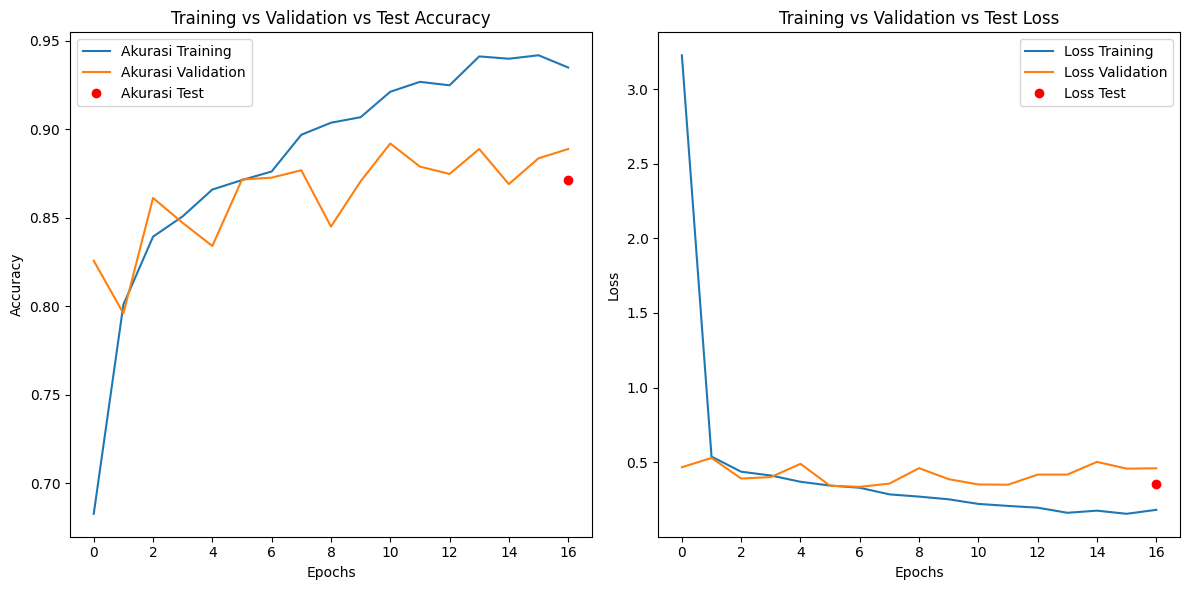

In [23]:
#✅ Kriteria Wajib: Membuat Plot Terhadap Akurasi dan Loss Model
import matplotlib.pyplot as plt

# Plot Akurasi
plt.figure(figsize=(12, 6))

# --- Plot Akurasi ---
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Training')
plt.plot(history.history['val_accuracy'], label='Akurasi Validation')
plt.plot(len(history.history['accuracy'])-1, test_accuracy, 'ro', label='Akurasi Test')  # Titik merah
plt.title('Training vs Validation vs Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# --- Plot Loss ---
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validation')
plt.plot(len(history.history['loss'])-1, test_loss, 'ro', label='Loss Test')  # Titik merah
plt.title('Training vs Validation vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Tampilkan grafik
plt.tight_layout()
plt.show()

# Save Model
✅ Kriteria Wajib: Menyimpan Model ke Dalam Format SavedModel, TF-Lite dan TFJS

In [24]:
#---- Format SavedModel ----

# 1. Buat Model Tanpa Augmentasi
export_model = Sequential([
    Input(shape=(128, 128, 3)),

    # Block 1
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),

    # Block 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),

    # Block 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(),

    # Block 4
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # Sesuai jumlah kelas kamu
])

# 2. Salin Bobot dari Model Latih ke Model Export
export_model.set_weights(model.get_weights())

# 3. Simpan ke Format SavedModel
save_path = 'saved_model/'
tf.saved_model.save(export_model, save_path)

In [25]:
#---- TF-Lite -----
import tensorflow as tf
import pathlib

converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()

tflite_model_file = pathlib.Path("tflite/model.tflite")
tflite_model_file.parent.mkdir(parents=True, exist_ok=True)
tflite_model_file.write_bytes(tflite_model)

# Simpan label
with open("tflite/label.txt", "w") as f:
    f.write("\n".join(train_ds.class_names))  # ganti sesuai kelas

W0000 00:00:1744985334.981550      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1744985334.981586      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1744985334.987995      31 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


In [ ]:
#---- TFJS -----
%pip install tensorflowjs
%tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is 

# Inferensi

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


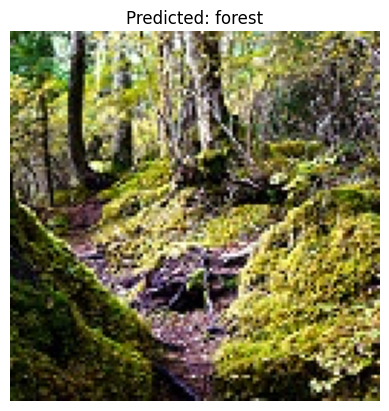

'forest'

In [28]:
# ✅ Kriteria Tambahan: Melakukan inference menggunakan salah satu model (TF-Lite, TFJS atau savedmodel).
from tensorflow.keras.preprocessing import image
import numpy as np

# Save the model in .keras format (recommended in Keras 3)
export_model.save('my_model.keras')

# To load the model
loaded_model = tf.keras.models.load_model('my_model.keras')

# Fungsi untuk memuat gambar dan melakukan inferensi
def predict_image(img_path):
    # Muat gambar
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)  # Konversi ke array numpy
    img_array = np.expand_dims(img_array, axis=0)  # Membuat batch dimensi (1, 128, 128, 3)
    img_array = img_array / 255.0  # Normalisasi gambar

    # Prediksi dengan model
    predictions = loaded_model.predict(img_array)
    
    # Menampilkan hasil
    predicted_class = train_ds.class_names[np.argmax(predictions)]

    # Tampilkan gambar dan hasil prediksi
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

    return predicted_class

# Contoh penggunaan
img_path = "/kaggle/input/intel-image-classification/seg_pred/seg_pred/10021.jpg"  # Ganti dengan path gambar tanpa label
predict_image(img_path)